In [1]:
from dask.distributed import LocalCluster
# from dask_jobqueue import SLURMCluster
from dask.distributed import Client

cluster = LocalCluster()
# cluster = SLURMCluster(cores=24, name='test', walltime='00:30:00',
#                        job_extra=['--constraint=HSW24','--exclusive','--nodes=1'], 
#                        memory='512GB', interface='ib0'
#                       ) 
cluster.scale(24)
# # cluster.adapt(minimum=1, maximum=48)

client = Client(cluster)
# client = Client()
client

/scratch/cnt0024/hmg2840/tuchida/envs/py38/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 45622 instead
  warnings.warn(


Client Scheduler: tcp://127.0.0.1:42778 Dashboard: http://127.0.0.1:45622/status,Cluster Workers: 24 Cores: 168 Memory: 754.89 GiB


In [2]:
import numpy as np
import xarray as xr
import pandas as pd
# import numpy_groupies
import dask.array as dsar
import xrft
import qgutils
from xgcm.grid import Grid
import os.path as op
# from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/store/CT1/hmg2840/tuchida/msqg/seas-forcing/'
rund = '/store/tuchida/msom/msqg/'
# ddir = '/store/CT1/hmg2840/tuchida/msqg/const-forcing/'

In [4]:
U = .1
T = 5e5      # seconds
tau0 = .0001
dt = 5e-2
Rd = 5e4     # Rossby radius (50km)
Re4 = 4e3
# f0 = 8e-5
beta = .5
N = 256*4    # Number of horizontal grids
L0 = 80
H = 5e3
dx = L0/N    # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny = 360
Rom = .025
Ekb = .002*2
ntime = 187

percent = 10
nmemb = 100

In [5]:
def pad_bc(psi, bc='dirichlet'):
    """
    Pad field psi with Dirichlet or Neumann boundary conditions
    Parameters
    ----------
    psi : array [nt,nz (,ny,nx)]
    bc   : 'dirichlet' or 'neumann'
    Returns
    -------
    psi_bc: array [nt,nz (,ny+2,nx+2)]
    """
    nd = psi.ndim
    # only pad horizontal dimensions
    if nd < 4:
        psi = qgutils.pad_bc(psi, bc=bc)
    else:
        if nd == 4:
            psi = np.pad(psi,((0,0),(0,0),(1,1),(1,1)),'constant')
        elif nd == 5:
            psi = np.pad(psi,((0,0),(0,0),(0,0),(1,1),(1,1)),'constant')

        if (bc == 'dirichlet'): 
            psi[...,0,:]  = -psi[...,1,:]
            psi[...,-1,:] = -psi[...,-2,:]
            psi[...,:,0]  = -psi[...,:,1]
            psi[...,:,-1] = -psi[...,:,-2]

            # corners
            psi[...,0,0]   = -psi[...,0,1]   - psi[...,1,0]   - psi[...,1,1]
            psi[...,-1,0]  = -psi[...,-1,1]  - psi[...,-2,0]  - psi[...,-2,1]
            psi[...,0,-1]  = -psi[...,1,-1]  - psi[...,0,-2]  - psi[...,1,-2]
            psi[...,-1,-1] = -psi[...,-1,-2] - psi[...,-2,-2] - psi[...,-2,-1]

        elif (bc == 'neumann'): 
            psi[...,0,:]  = psi[...,1,:]
            psi[...,-1,:] = psi[...,-2,:]
            psi[...,:,0]  = psi[...,:,1]
            psi[...,:,-1] = psi[...,:,-2]

            # corners
            psi[...,0,0]   = psi[...,1,1]
            psi[...,-1,0]  = psi[...,-2,1]
            psi[...,0,-1]  = psi[...,1,-2]
            psi[...,-1,-1] = psi[...,-2,-2]

    return psi


def laplacian(psi, Delta=1, bc='dirichlet', padded=False, 
              dim=['Z','Yp1','Xp1'], chunks={'Yp1':100,'Xp1':100}
             ):
    
    nd = psi.ndim
    if padded:
        psi_padded = psi
    else:
        if nd == 3:
            psi_padded = xr.DataArray(qgutils.pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)
        else:
            psi_padded = xr.DataArray(pad_bc(psi), dims=dim,
                                      coords={'Yp1':np.arange(-dx/2,L0+dx,dx),
                                              'Xp1':np.arange(-dx/2,L0+dx,dx)}
                                     ).chunk(chunks)

    lap = (psi_padded.isel(Yp1=slice(2,None),Xp1=slice(1,-1)).data 
           + psi_padded.isel(Yp1=slice(None,-2),Xp1=slice(1,-1)).data
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(2,None)).data 
           + psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(None,-2)).data
           - 4*psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).data
          ) / Delta**2

    return xr.DataArray(lap, dims=psi_padded.dims, 
                        coords=psi_padded.isel(Yp1=slice(1,-1),Xp1=slice(1,-1)).coords
                       )

distributed.utils_perf - WARNING - full garbage collections took 38% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 46% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 45% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 44% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 43% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

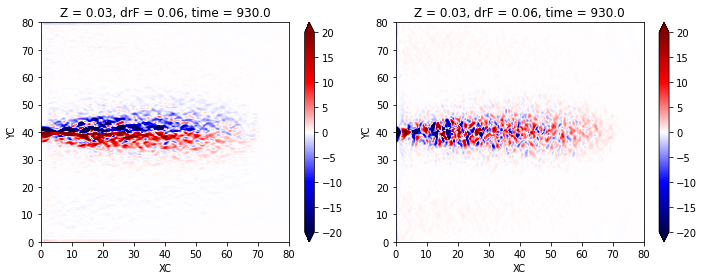

<xarray.Dataset>
Dimensions:  (XC: 1024, YC: 1024, Z: 3, time: 4)
Coordinates:
  * XC       (XC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * YC       (YC) float64 0.03906 0.1172 0.1953 0.2734 ... 79.8 79.88 79.96
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * time     (time) float32 930.0 931.0 932.0 933.0
Data variables:
    upqp     (time, Z, YC, XC) float32 dask.array<chunksize=(4, 3, 128, 128), meta=np.ndarray>
    vpqp     (time, Z, YC, XC) float32 dask.array<chunksize=(4, 3, 128, 128), meta=np.ndarray>
    upPp0    (time, Z, YC, XC) float32 dask.array<chunksize=(4, 3, 128, 128), meta=np.ndarray>
    vpPp0    (time, Z, YC, XC) float32 dask.array<chunksize=(4, 3, 128, 128), meta=np.ndarray>
    upPp1    (time, Z, YC, XC) float32 dask.array<chunksize=(4, 3, 128, 128), meta=np.ndarray>
    vpPp1    (time, Z, YC, XC) float32 dask.array<chunksize=(4, 3, 128, 128), meta=np.ndarray>
    upPp2    (time, Z, 

In [6]:
dtt = 7
ttstart = 44
ver = 2

for tt in range(ttstart,int(312/dtt)+1):
    
    for i in range(nmemb+1):
        if i < nmemb:
            if i == 0:
                q = xr.open_zarr(op.join(rund, 'run%03d/vars%03d' % (i,ver))
                                ).q.isel(time=slice(tt*dtt,tt*dtt+dtt))
            else:
                q = xr.concat([q,xr.open_zarr(op.join(rund, 'run%03d/vars%03d' % (i,ver))
                                             ).q.isel(time=slice(tt*dtt,tt*dtt+dtt))
                              ], 'nmemb')
        else:
            q = xr.concat([q,xr.open_zarr(op.join(rund, 'ctrl/vars%03d' % ver)
                                          ).q.isel(time=slice(tt*dtt,tt*dtt+dtt))
                          ], 'nmemb')

    if tt < 44:
        dsp = xr.open_zarr(op.join(rund,"Eddy%03d/%03d-%03d" % (ver,tt*dtt,tt*dtt+dtt-1)))
        dst = xr.open_zarr(op.join(rund,"EddyPTR%03d/%03d-%03d" % (ver,tt*dtt,tt*dtt+dtt-1)))
    else:
        dsp = xr.open_zarr(op.join(rund,"Eddy%03d/%03d-%03d" % (ver,308,311)))
        dst = xr.open_zarr(op.join(rund,"EddyPTR%03d/%03d-%03d" % (ver,308,311)))
    
    
    qp = q - q.mean('nmemb')
    up = -dsp.psip.isel(Xp1=slice(1,-1)).diff('Yp1') / dx
    vp = dsp.psip.isel(Yp1=slice(1,-1)).diff('Xp1') / dx
    
    upqp = (qp * (    up.isel(Yp1=slice(1,None)).data 
                  +   up.isel(Yp1=slice(None,-1)).data)*.5
           ).mean('nmemb').compute()
    vpqp = (qp * (    vp.isel(Xp1=slice(1,None)).data 
                  +   vp.isel(Xp1=slice(None,-1)).data)*.5
           ).mean('nmemb').compute()
    upP0 = (dst.ptr0p * (    up.isel(Yp1=slice(1,None)).data 
                         +   up.isel(Yp1=slice(None,-1)).data)*.5
           ).mean('nmemb').compute()
    vpP0 = (dst.ptr0p * (    vp.isel(Xp1=slice(1,None)).data 
                         +   vp.isel(Xp1=slice(None,-1)).data)*.5
           ).mean('nmemb').compute()
    upP1 = (dst.ptr1p * (    up.isel(Yp1=slice(1,None)).data 
                         +   up.isel(Yp1=slice(None,-1)).data)*.5
           ).mean('nmemb').compute()
    vpP1 = (dst.ptr1p * (    vp.isel(Xp1=slice(1,None)).data 
                         +   vp.isel(Xp1=slice(None,-1)).data)*.5
           ).mean('nmemb').compute()
    upP2 = (dst.ptr2p * (    up.isel(Yp1=slice(1,None)).data 
                         +   up.isel(Yp1=slice(None,-1)).data)*.5
           ).mean('nmemb').compute()
    vpP2 = (dst.ptr2p * (    vp.isel(Xp1=slice(1,None)).data 
                         +   vp.isel(Xp1=slice(None,-1)).data)*.5
           ).mean('nmemb').compute()
    upP3 = (dst.ptr3p * (    up.isel(Yp1=slice(1,None)).data 
                         +   up.isel(Yp1=slice(None,-1)).data)*.5
           ).mean('nmemb').compute()
    vpP3 = (dst.ptr3p * (    vp.isel(Xp1=slice(1,None)).data 
                         +   vp.isel(Xp1=slice(None,-1)).data)*.5
           ).mean('nmemb').compute()
    
    if tt == ttstart:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
        fig.set_tight_layout(True)
        upqp.isel(time=0,Z=0).plot(ax=ax1, vmax=20., cmap='seismic')
        vpqp.isel(time=0,Z=0).plot(ax=ax2, vmax=20., cmap='seismic')
        plt.show()
    
    
    dsave = upqp.to_dataset(name='upqp')
    dsave['vpqp'] = vpqp
    dsave['upPp0'] = upP0
    dsave['vpPp0'] = vpP0
    dsave['upPp1'] = upP1
    dsave['vpPp1'] = vpP1
    dsave['upPp2'] = upP2
    dsave['vpPp2'] = vpP2
    dsave['upPp3'] = upP3
    dsave['vpPp3'] = vpP3
    dsave = dsave.chunk({'time':-1,'YC':128,'XC':128})
    if tt == ttstart:
        print(dsave)
    dsave.to_zarr(op.join(rund,'EddyFlux%03d/%03d-%03d/' 
                          % (ver,tt*dtt,tt*dtt+len(dsp.time)-1)), mode='w'
                 )
    dsave.close()
    dsp.close()
    dst.close()
    print(tt)

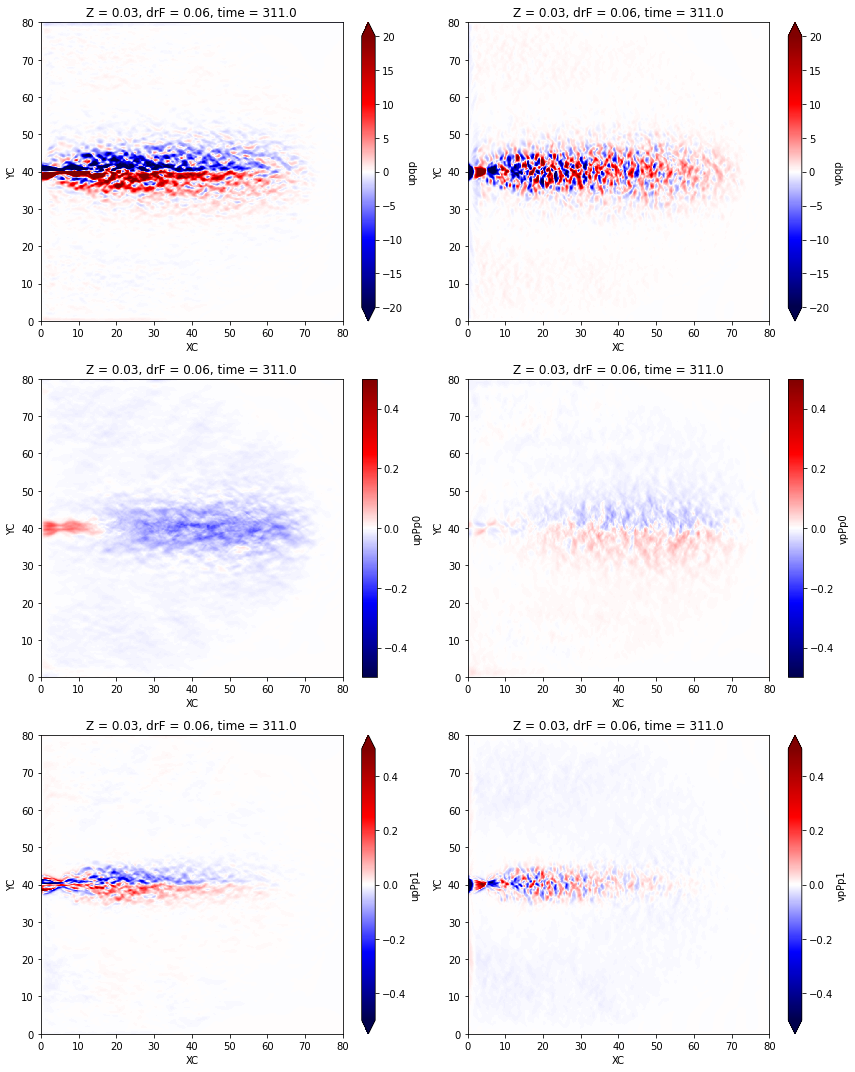

In [8]:
ds = xr.open_zarr(op.join(rund,'EddyFlux001/%03d-%03d/' % (0,6)))

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12,15))
fig.set_tight_layout(True)
ds.upqp.isel(time=0,Z=0).plot(ax=axes[0,0], vmax=20., cmap='seismic')
ds.vpqp.isel(time=0,Z=0).plot(ax=axes[0,1], vmax=20., cmap='seismic')
ds.upPp0.isel(time=0,Z=0).plot(ax=axes[1,0], vmax=.5, cmap='seismic')
ds.vpPp0.isel(time=0,Z=0).plot(ax=axes[1,1], vmax=.5, cmap='seismic')
ds.upPp1.isel(time=0,Z=0).plot(ax=axes[2,0], vmax=.5, cmap='seismic')
ds.vpPp1.isel(time=0,Z=0).plot(ax=axes[2,1], vmax=.5, cmap='seismic')

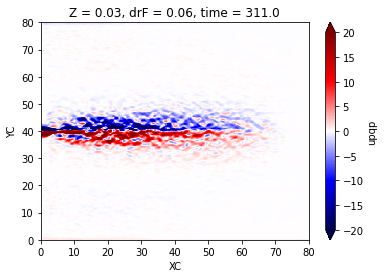

In [9]:
ds.upqp.isel(time=0,Z=0).coarsen(YC=4, XC=4, boundary='exact').mean().plot(vmax=20., cmap='seismic')

In [8]:
# Convert to netcdf for transport
dtt = 7
ncoars = 4
ttstart = 0
ver = 2


for tt in range(ttstart,int(312/dtt)+1):
    
    
    for i in range(nmemb+1):
        if i < nmemb:
            if i == 0:
                q = xr.open_zarr(op.join(rund, 'run%03d/vars%03d' % (i,ver))
                                ).q.isel(time=slice(tt*dtt,tt*dtt+dtt))
            else:
                q = xr.concat([q,xr.open_zarr(op.join(rund, 'run%03d/vars%03d' % (i,ver))
                                             ).q.isel(time=slice(tt*dtt,tt*dtt+dtt))
                              ], 'nmemb')
        else:
            q = xr.concat([q,xr.open_zarr(op.join(rund, 'ctrl/vars%03d' % ver)
                                         ).q.isel(time=slice(tt*dtt,tt*dtt+dtt))
                          ], 'nmemb')
    

    if tt < 44:
        dsb = xr.open_zarr(op.join(rund,"MeanPTR%03d/%03d-%03d" 
                                   % (ver,tt*dtt,tt*dtt+dtt-1)))
        dsp = xr.open_zarr(op.join(rund,"EddyFlux%03d/%03d-%03d" 
                                   % (ver,tt*dtt,tt*dtt+dtt-1)))
    else:
        dsb = xr.open_zarr(op.join(rund,"MeanPTR%03d/%03d-%03d" 
                                   % (ver,308,311)))
        dsp = xr.open_zarr(op.join(rund,"EddyFlux%03d/%03d-%03d" 
                                   % (ver,308,311)))
    
    P0b = dsb.ptr0b.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    P1b = dsb.ptr1b.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    P2b = dsb.ptr2b.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    P3b = dsb.ptr3b.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    
    DX = dx * ncoars
    if tt == 0:
        qb = xr.DataArray(pad_bc(q.mean('nmemb').coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()),
                          dims=q.isel(nmemb=0).dims,
                          coords={'time':q.time,'Z':q.Z,
                                  'YC':np.arange(-DX/2,L0+DX,DX),
                                  'XC':np.arange(-DX/2,L0+DX,DX)})
        P0 = xr.DataArray(pad_bc(P0b), dims=P0b.dims,
                          coords={'time':P0b.time,'Z':P0b.Z,
                                  'YC':np.arange(-DX/2,L0+DX,DX),
                                  'XC':np.arange(-DX/2,L0+DX,DX)})
        P1 = xr.DataArray(pad_bc(P1b), dims=P0b.dims,
                          coords={'time':P0b.time,'Z':P0b.Z,
                                  'YC':np.arange(-DX/2,L0+DX,DX),
                                  'XC':np.arange(-DX/2,L0+DX,DX)})
        P2 = xr.DataArray(pad_bc(P2b), dims=P0b.dims,
                          coords={'time':P0b.time,'Z':P0b.Z,
                                  'YC':np.arange(-DX/2,L0+DX,DX),
                                  'XC':np.arange(-DX/2,L0+DX,DX)})
        P3 = xr.DataArray(pad_bc(P3b), dims=P0b.dims,
                          coords={'time':P0b.time,'Z':P0b.Z,
                                  'YC':np.arange(-DX/2,L0+DX,DX),
                                  'XC':np.arange(-DX/2,L0+DX,DX)})
        upqp = dsp.upqp.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        vpqp = dsp.vpqp.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        upP0p = dsp.upPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        vpP0p = dsp.vpPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        upP1p = dsp.upPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        vpP1p = dsp.vpPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        upP2p = dsp.upPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        vpP2p = dsp.vpPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        upP3p = dsp.upPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
        vpP3p = dsp.vpPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
    else:
        qb = xr.concat([qb,xr.DataArray(pad_bc(q.mean('nmemb').coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()), 
                                        dims=q.isel(nmemb=0).dims,
                                        coords={'time':q.time,'Z':q.Z,
                                                'YC':np.arange(-DX/2,L0+DX,DX),
                                                'XC':np.arange(-DX/2,L0+DX,DX)})
                       ], 'time')
        P0 = xr.concat([P0,xr.DataArray(pad_bc(P0b), dims=P0b.dims,
                                        coords={'time':P0b.time,'Z':P0b.Z,
                                                'YC':np.arange(-DX/2,L0+DX,DX),
                                                'XC':np.arange(-DX/2,L0+DX,DX)})
                       ], 'time')
        P1 = xr.concat([P1,xr.DataArray(pad_bc(P1b), dims=P1b.dims,
                                        coords={'time':P1b.time,'Z':P1b.Z,
                                                'YC':np.arange(-DX/2,L0+DX,DX),
                                                'XC':np.arange(-DX/2,L0+DX,DX)})
                       ], 'time')
        P2 = xr.concat([P2,xr.DataArray(pad_bc(P2b), dims=P2b.dims,
                                        coords={'time':P2b.time,'Z':P2b.Z,
                                                'YC':np.arange(-DX/2,L0+DX,DX),
                                                'XC':np.arange(-DX/2,L0+DX,DX)})
                       ], 'time')
        P3 = xr.concat([P3,xr.DataArray(pad_bc(P3b), dims=P3b.dims,
                                        coords={'time':P3b.time,'Z':P3b.Z,
                                                'YC':np.arange(-DX/2,L0+DX,DX),
                                                'XC':np.arange(-DX/2,L0+DX,DX)})
                       ], 'time')
        upqp = xr.concat([upqp, dsp.upqp.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                         ], 'time')
        vpqp = xr.concat([vpqp, dsp.vpqp.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                         ], 'time')
        upP0p = xr.concat([upP0p, dsp.upPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        vpP0p = xr.concat([vpP0p, dsp.vpPp0.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        upP1p = xr.concat([upP1p, dsp.upPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        vpP1p = xr.concat([vpP1p, dsp.vpPp1.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        upP2p = xr.concat([upP2p, dsp.upPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        vpP2p = xr.concat([vpP2p, dsp.vpPp2.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        upP3p = xr.concat([upP3p, dsp.upPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')
        vpP3p = xr.concat([vpP3p, dsp.vpPp3.coarsen(YC=ncoars, XC=ncoars, boundary='exact').mean()
                          ], 'time')


    dsp.close()
    dsb.close()
    print(tt)
    
dsave = qb.to_dataset(name='qb')
dsave['P0b'] = P0
dsave['P1b'] = P1
dsave['P2b'] = P2
dsave['P3b'] = P3
dsave.to_netcdf(op.join(rund,'MeanPTR%03d/netcdf/n%02d_last5yrs.nc' 
                        % (ver,ncoars)), 
                mode='w')
print(dsave)
dsave.close()

dsave = upqp.to_dataset(name='upqp')
dsave['vpqp'] = vpqp
dsave['upP0p'] = upP0p
dsave['vpP0p'] = vpP0p
dsave['upP1p'] = upP1p
dsave['vpP1p'] = vpP1p
dsave['upP2p'] = upP2p
dsave['vpP2p'] = vpP2p
dsave['upP3p'] = upP3p
dsave['vpP3p'] = vpP3p
dsave.to_netcdf(op.join(rund,'EddyFlux%03d/netcdf/n%02d_last5yrs.nc' 
                        % (ver,ncoars)), 
                mode='w')
print(dsave)
dsave.close()

0
1
2
3
4
5
6


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)


7


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

8


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

9


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

10


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

11


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

12


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

13


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

14


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

15


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

16


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

17


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

18


distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 14% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

19


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

20


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

21


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

22


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

23


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

24


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

25


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

26


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

27


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

28


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

29


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

30


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

31


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

32


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

33


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

34


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

35


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

36


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

37


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

38


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

39


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

40


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

41


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

42


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

43


distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

44
<xarray.Dataset>
Dimensions:  (XC: 258, YC: 258, Z: 3, time: 312)
Coordinates:
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
  * Z        (Z) float64 0.03 0.13 0.6
  * YC       (YC) float64 -0.1562 0.1562 0.4688 0.7812 ... 79.53 79.84 80.16
  * XC       (XC) float64 -0.1562 0.1562 0.4688 0.7812 ... 79.53 79.84 80.16
Data variables:
    qb       (time, Z, YC, XC) float32 2.177 -2.177 ... 1.168e-05 -1.168e-05
    P0b      (time, Z, YC, XC) float32 -0.461 0.461 0.449 ... -0.9695 0.9695
    P1b      (time, Z, YC, XC) float32 -0.8709 0.8709 0.8677 ... -0.9695 0.9695
    P2b      (time, Z, YC, XC) float32 0.4745 -0.4745 ... 0.09502 -0.09502
    P3b      (time, Z, YC, XC) float32 0.3205 -0.3205 ... 0.09499 -0.09499


distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 13% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256, Z: 3, time: 312)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 0.06 0.14 0.8
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
Data variables:
    upqp     (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 32, 32), meta=np.ndarray>
    vpqp     (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 32, 32), meta=np.ndarray>
    upP0p    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 32, 32), meta=np.ndarray>
    vpP0p    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 32, 32), meta=np.ndarray>
    upP1p    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 32, 32), meta=np.ndarray>
    vpP1p    (time, Z, YC, XC) float32 dask.array<chunksize=(7, 3, 32, 32), meta=np.ndarray>
    upP2p    (time, Z, YC, 

In [11]:
client.close()